In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
from img2vec_pytorch import Img2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
base_folder = 'video_anomaly_detection_frames'
images = []

for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    for filename in os.listdir(subfolder_path):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(subfolder_path, filename)

            with Image.open(img_path) as img:
                width, height = img.size
                cropped_img = img.crop((100, 100, width, height))
                images.append(cropped_img)

In [9]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img


In [10]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageDataset(images, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(256 * 16 * 16, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 16 * 16)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 16, 16)
        return self.net(x)


In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)


In [35]:
adv_loss = nn.BCELoss()
recon_loss = nn.L1Loss()

optim_G = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=2e-4
)

optim_D = optim.Adam(discriminator.parameters(), lr=2e-4)


In [36]:
for epoch in range(50):
    for imgs in loader:
        imgs = imgs.to(device)
        z = encoder(imgs)
        recon = decoder(z)

        valid = torch.ones(imgs.size(0), 1).to(device)

        g_loss = (
            recon_loss(recon, imgs) +
            adv_loss(discriminator(recon), valid)
        )

        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()

        fake = torch.zeros(imgs.size(0), 1).to(device)

        d_loss = (
            adv_loss(discriminator(imgs), valid) +
            adv_loss(discriminator(recon.detach()), fake)
        )

        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()

    print(f"Epoch {epoch} | G: {g_loss.item():.3f} | D: {d_loss.item():.3f}")


Epoch 0 | G: 0.869 | D: 1.369
Epoch 1 | G: 0.984 | D: 1.393
Epoch 2 | G: 1.089 | D: 1.383
Epoch 3 | G: 0.739 | D: 1.388
Epoch 4 | G: 0.883 | D: 1.388
Epoch 5 | G: 1.032 | D: 1.378
Epoch 6 | G: 0.738 | D: 1.387
Epoch 7 | G: 0.744 | D: 1.386
Epoch 8 | G: 0.906 | D: 1.379
Epoch 9 | G: 0.861 | D: 1.385
Epoch 10 | G: 0.741 | D: 1.386
Epoch 11 | G: 0.978 | D: 1.374
Epoch 12 | G: 0.732 | D: 1.387
Epoch 13 | G: 0.736 | D: 1.386
Epoch 14 | G: 0.771 | D: 1.385
Epoch 15 | G: 0.764 | D: 1.385
Epoch 16 | G: 0.911 | D: 1.371
Epoch 17 | G: 0.725 | D: 1.386
Epoch 18 | G: 0.838 | D: 1.370
Epoch 19 | G: 0.788 | D: 1.377
Epoch 20 | G: 0.757 | D: 1.387
Epoch 21 | G: 0.758 | D: 1.386
Epoch 22 | G: 0.790 | D: 1.386
Epoch 23 | G: 0.807 | D: 1.372
Epoch 24 | G: 0.729 | D: 1.383
Epoch 25 | G: 0.716 | D: 1.386
Epoch 26 | G: 0.795 | D: 1.368
Epoch 27 | G: 0.815 | D: 1.367
Epoch 28 | G: 0.716 | D: 1.385
Epoch 29 | G: 0.719 | D: 1.386
Epoch 30 | G: 0.874 | D: 1.370
Epoch 31 | G: 0.720 | D: 1.387
Epoch 32 | G: 0.71

In [37]:
encoder.eval()
embeddings = []

with torch.no_grad():
    for imgs in loader:
        imgs = imgs.to(device)
        z = encoder(imgs)
        embeddings.append(z.cpu())

embeddings = torch.cat(embeddings).numpy()


In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
platform_ids = kmeans.fit_predict(embeddings)


In [39]:
def anomaly_score(img):
    z = encoder(img.unsqueeze(0))
    recon = decoder(z)
    return torch.mean(torch.abs(img - recon)).item()


In [47]:
def visualize_embeddings_tsne(embeddings, platform_ids=None):
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    if platform_ids is not None:
        for pid in np.unique(platform_ids):
            plt.scatter(emb_2d[platform_ids==pid,0], emb_2d[platform_ids==pid,1], label=f'Platform {pid}')
        plt.legend()
    else:
        plt.scatter(emb_2d[:,0], emb_2d[:,1])
    plt.title("t-SNE of Embeddings")
    plt.show()

def visualize_embeddings_anomaly(embeddings, scores):
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=scores, cmap='hot', s=50)
    plt.colorbar(scatter, label='Anomaly Score')
    plt.title("t-SNE of Embeddings Colored by Anomaly Score")
    plt.show()

In [43]:
from sklearn.manifold import TSNE

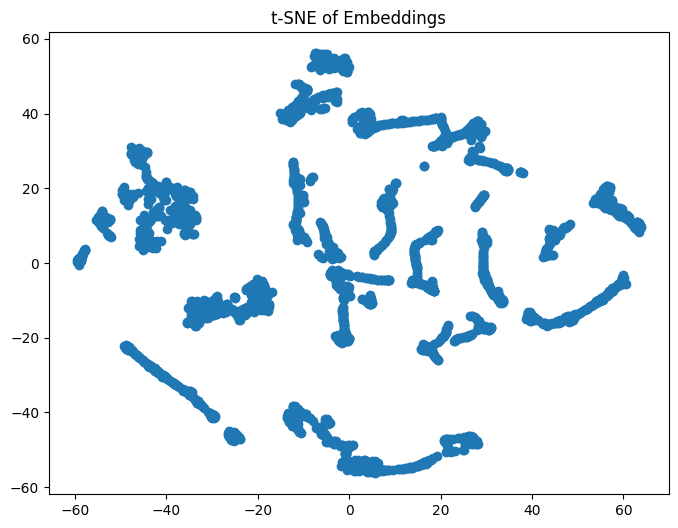

In [46]:
visualize_embeddings_tsne(embeddings)


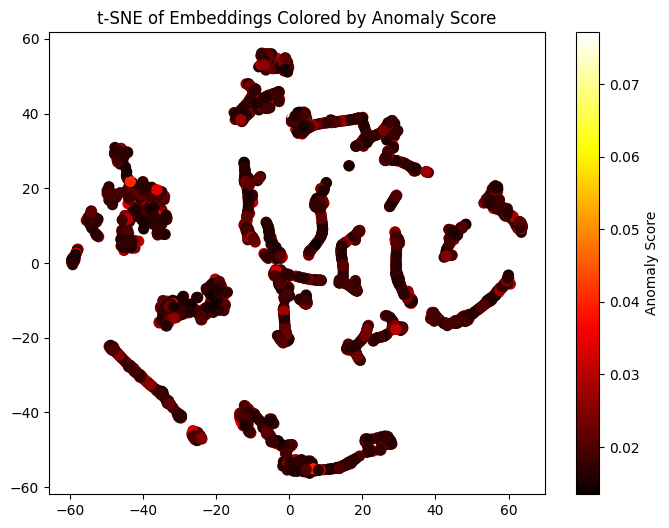

In [45]:
scores = [anomaly_score(img.to(device)) for img in dataset]
visualize_embeddings_anomaly(embeddings, scores)